## Least squares TDOA and TOA is not a convex problem

If we work with a time-difference-of-arrival system where a single transmission is simultaneously received by multiple receivers, we could try to express it as a least square minimization problem

$$ \begin{align}
min & \: \epsilon^T W \epsilon \\
s.t. & \: t_i = \tau + \| p - \pi_i\| + \epsilon_i
\end{align}$$

Here

- $i$ represents the reception on a $i^\text{th}$ receiver
- $t_i$ is the time of the reception
- $\tau$ is the time of transmission
- $p$ is the position of the transmitter
- $\pi_i$ is the position of the $i^\text{th}$ receiver.
- $\epsilon_i$ is the error caused by violating each constraint. Correspondingly, $\epsilon$ is a vector of $\epsilon_i$'s

This problem formulation is not convex. Thus it cannot be solved by standard quadratic optimization, cone programming or semidefinite methods.

One possibility is to use gradient desent with the appropriate starting points.

I tried a simplification as follows which instead converted the problem into TOA (instead of TDOA)

Note that $t_i - \tau = \frac{\text{actual distance}}{c}$
Thus the constrains become $\frac{\text{actual dist}_i}{c} = \frac{\text{estimated dist}_i}{c} + \epsilon_i$

Transmitter:  device TX at pos = [   0. 5000.]
Receivers used: 2


<IPython.core.display.Javascript object>


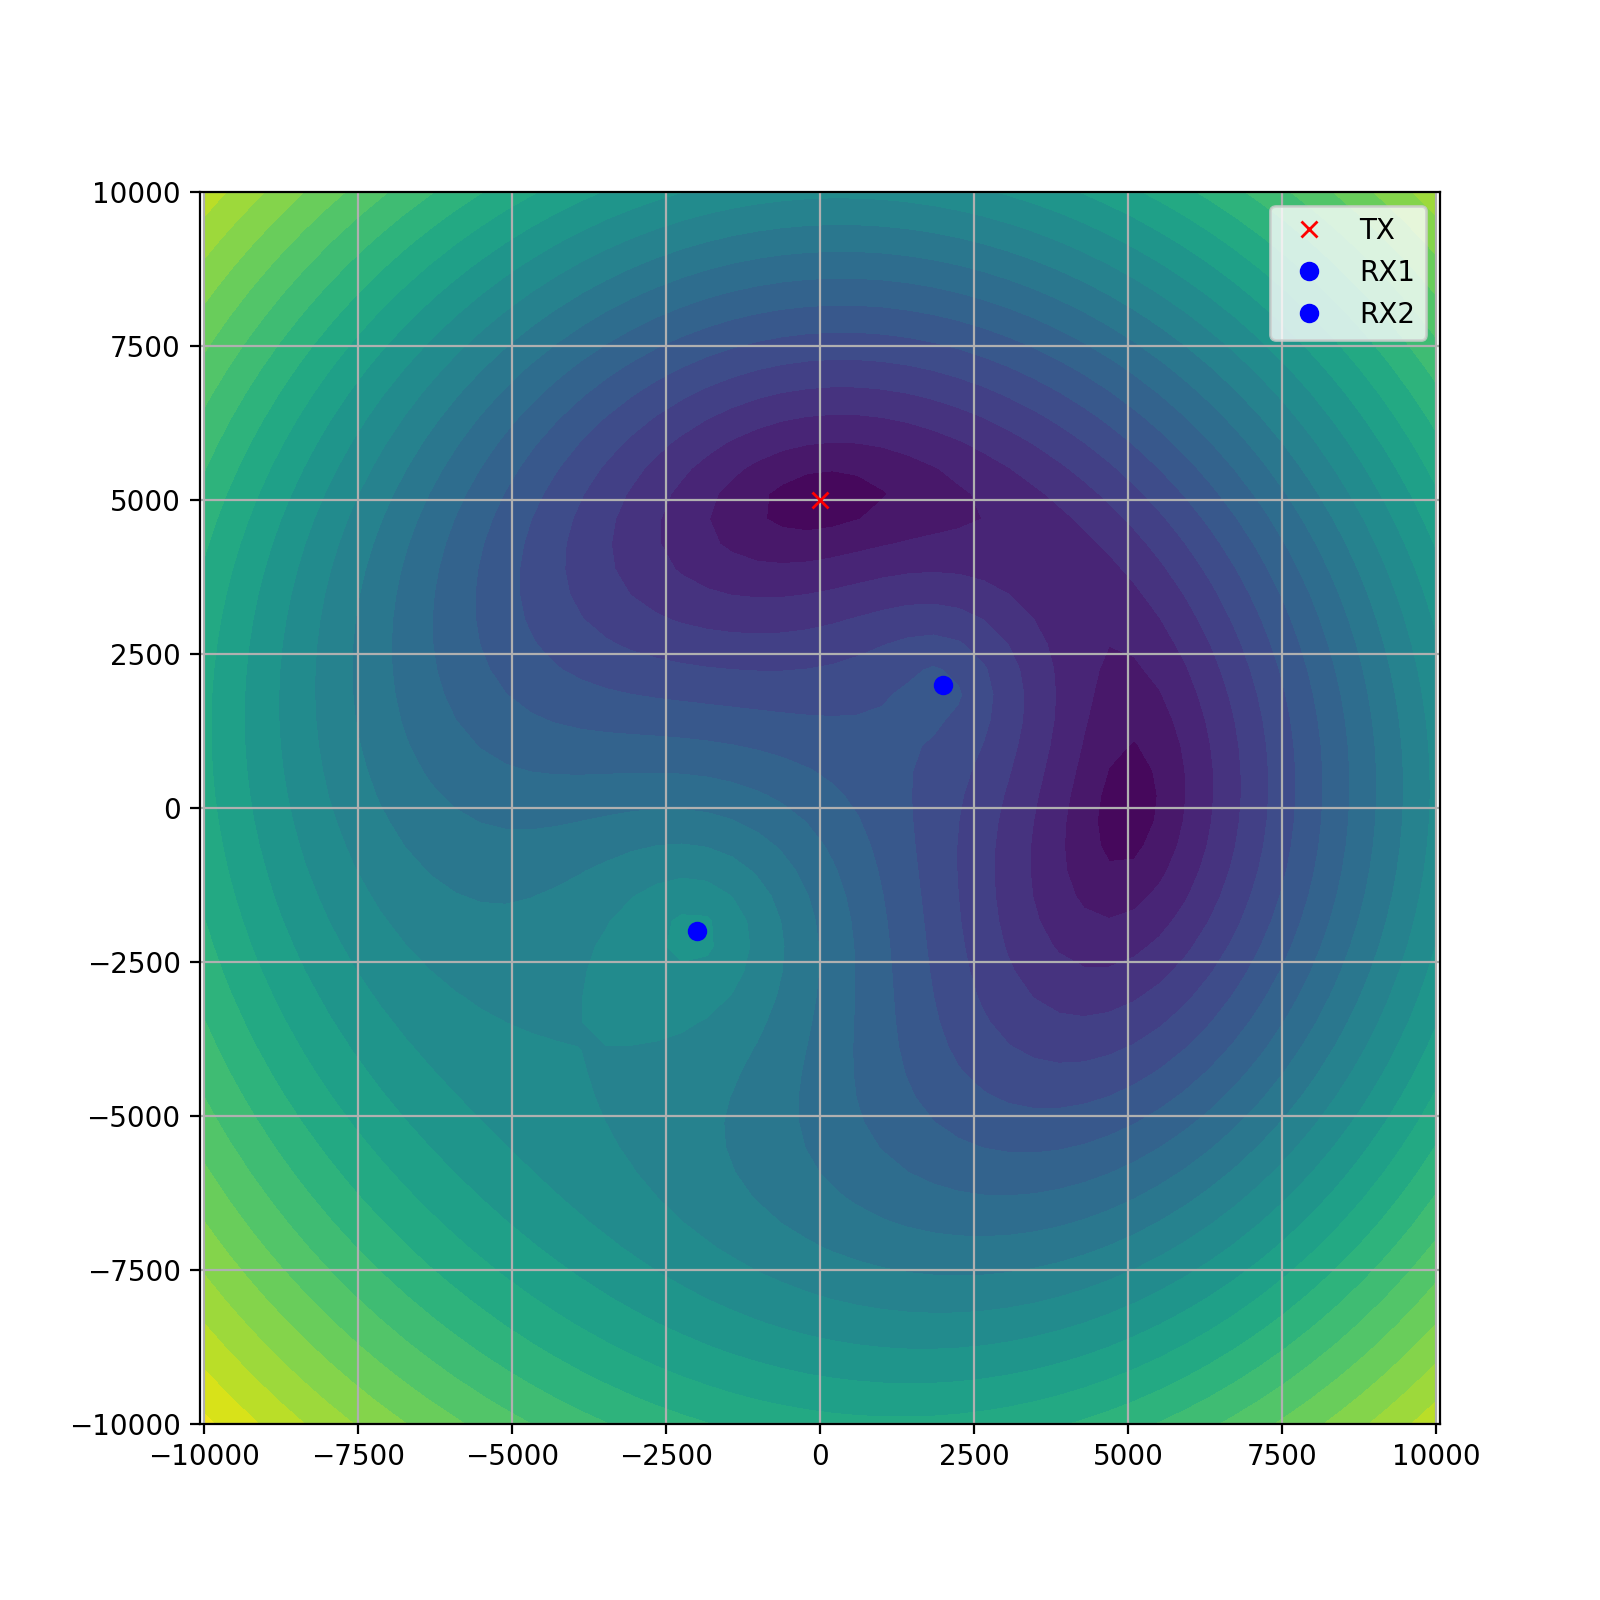

In [42]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

def pos(x,y):
    """Quick shortcut to convert X,Y position to numpy array"""
    return np.array([x,y])

def pos3D(x,y,z):
    """Quick shortcut to convert X,Y,Z position to numpy array"""
    return np.array([x,y,z])

class Device:
    """This is a general class for a radio device"""
    def __init__(self, name, position):
        """Expects a string for name and a numpy array with position coordinates in meters"""
        self.name = name
        self.pos = position
        
    def __str__(self):
        """Display string"""
        return "device {} at pos = {}".format(self.name, self.pos)
    
    def distanceTo(self, otherDevice):
        """When supplied the identity of another device, outputs the distance in meters"""
        return np.linalg.norm(self.pos - otherDevice.pos, ord = 2)
    
    def distances(self, positions):
        """Given a multi dimensional array of positions with the coordinates in the last axis,
        this function finds the distance to each of those points"""
        nDim = len(positions.shape)
        return np.linalg.norm(positions - self.pos, ord = 2, axis = nDim-1)
    
    def plot(self, *args, **kwargs):
        plt.plot(self.pos[0], self.pos[1], *args, label = self.name, **kwargs)
        
def combinedPositionMatrix(deviceList):
    """Given a list of Devices, give a numpy array with just their positions in a single matrix.
    Each device position is a row. Order of the devices is maintained"""
    n = len(deviceList)
    positions = np.empty([n, 2]) # Assuming 2D space
    for index, dev in enumerate(deviceList):
        positions[index] = dev.pos
    return positions
    
# all positions are in m
# TODO: find a situation where we have a local minima

def ToaErrorFunction(TX, RX,
                     numPoints = 100,
                     contours = 25,
                     size = ((-2000,2000),(-2000,2000)),
                     noiseStdev = 0, # standard deviation of noise
                     **kwargs):
    
    # interpret inputs and settings
    txName, txPos = next(iter(TX.items())) # get exactly one item from the dict (there should only be 1)
    tx = Device(txName, pos(*txPos))
    print("Transmitter: ", tx)
    rxDevices = []
    for rxName, rxPos in RX.items():
        rxDevices.append(Device(rxName,pos(*rxPos)))
    print("Receivers used: {}".format(len(rxDevices)))
    ((xMin, xMax), (yMin, yMax)) = size
    
    # generate grid
    x1 = np.linspace(xMin, xMax, numPoints)
    x2 = np.linspace(yMin, yMax, numPoints)
    x1,x2 = np.meshgrid(x1, x2)
    meshgridDim = len(x1.shape)
    # The position matrix contains coordinates of multiple points in a multi dimensional grid.
    # The coordinates are in the last axis
    positions = np.stack((x1, x2), axis = meshgridDim)

    # calculate error at all points on the grid
    def getTotalError(txDevice, rxDevices, positions):
        """Add description"""
        nRxDevices = len(rxDevices)
        error = np.empty([nRxDevices, *positions.shape[0:-1]])

        def getError(txDevice, rxDevice, positions):
            """Add description"""
            measuredDistance = rxDevice.distanceTo(txDevice) + np.random.normal(scale = noiseStdev)
            estimatedDistance = rxDevice.distances(positions)
            error = measuredDistance - estimatedDistance
            return error
        
        for devIndex, dev in enumerate(rxDevices):
            error[devIndex] = getError(txDevice, dev, positions)
        return np.linalg.norm(error, ord = 2, axis = 0)

    errorGrid = getTotalError(tx, rxDevices, positions)
    
    # plot and show
    plt.figure(figsize=(8,8))
    plt.axis('equal')
    plt.xlim([xMin, xMax])
    plt.ylim([yMin, yMax])
    tx.plot('rx')
    for dev in rxDevices:
        dev.plot('bo')
    plt.contourf(x1, x2, errorGrid, contours)
    plt.legend()
    plt.grid()
    # plt.show()
    
# setup simulation parameters
settings = {
            'TX': {
                    'TX': (0.,5000.)
                },
            'RX': {
                    'RX1': (-2000., -2000),
                    'RX2': (2000, 2000),
#                     'RX3': (-2000, 2000),
#                     'RX4': (2000, -2000),
#                     'RX5': (0, 3000),
#                     'RX6': pos(0, -3000)
                 },
            'numPoints': 50,
            'contours': 25,
            'size': ((-10000, 10000), (-10000, 10000))
           }

# run simulation with provided parameters
ToaErrorFunction(**settings)

{'TX': {'TX': (0.0, 5000.0)}, 'RX': {'RX1': (-2000.0, -2000), 'RX2': (2000, 2000), 'RX3': (-2000, 2000), 'RX4': (2000, -2000), 'RX5': (0, 3000), 'RX6': array([    0, -3000])}, 'nPoints': 50}


<IPython.core.display.Javascript object>


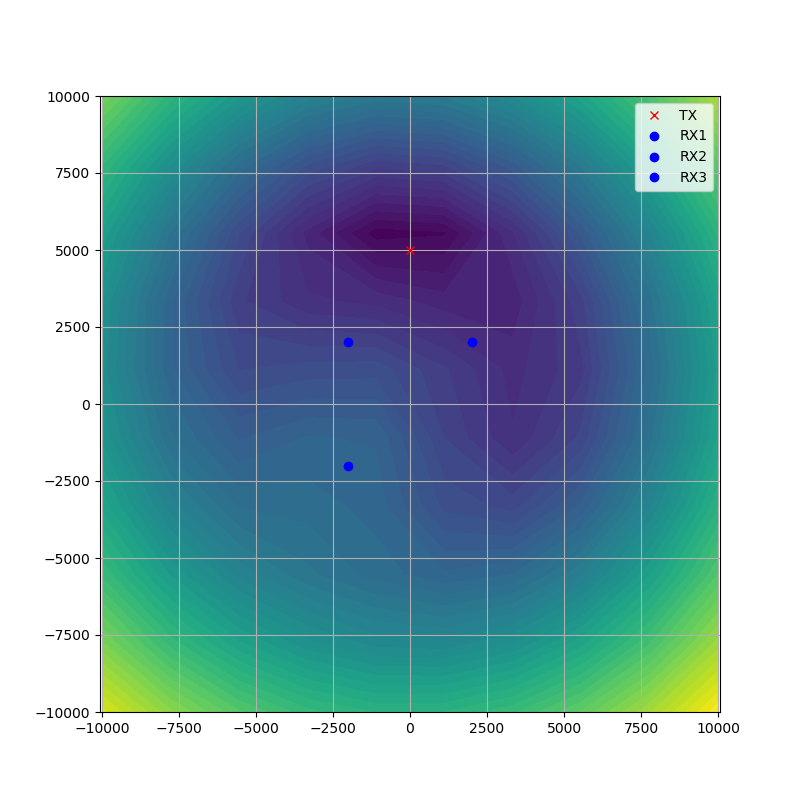

In [4]:
tx = Device('TX', pos(0,5000))
rx1 = Device('RX1', pos(-2000., -2000))
rx2 = Device('RX2', pos(2000, 2000))
rx3 = Device('RX3', pos(-2000, 2000))
rx4 = Device('RX4', pos(2000, -2000))
rx5 = Device('RX5', pos(0, 3000))
rx6 = Device('RX6', pos(0, -3000))

rxDevices = [rx1, rx2, rx3]

x1 = np.linspace(-10000, 10000, 10)
x2 = np.linspace(-10000, 10000, 10)
x1,x2 = np.meshgrid(x1, x2)
meshgridDim = len(x1.shape)

# The position matrix contains coordinates of multiple points in a multi dimensional grid.
# The coordinates are in the last axis
positions = np.stack((x1, x2), axis = meshgridDim)

noiseStdev = 300.0 # standard deviation of noise

def getError(txDevice, rxDevice, positions):
    measuredDistance = rxDevice.distanceTo(txDevice) + np.random.normal(scale = noiseStdev)
    estimatedDistance = rxDevice.distances(positions)
    error = measuredDistance - estimatedDistance
    return error

def getTotalError(txDevice, rxDevices, positions):
    nRxDevices = len(rxDevices)
    error = np.empty([nRxDevices, *positions.shape[0:-1]])
    for devIndex, dev in enumerate(rxDevices):
        error[devIndex] = getError(txDevice, dev, positions)
    return np.linalg.norm(error, ord = 2, axis = 0)

errorGrid = getTotalError(tx, rxDevices, positions)

# plot and show
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.xlim([-10000, 10000])
plt.ylim([-10000, 10000])

tx.plot('rx')

for dev in rxDevices:
    dev.plot('bo')
    
plt.contourf(x1, x2, errorGrid, 50)
plt.legend()
plt.grid()
# plt.show()

<IPython.core.display.Javascript object>


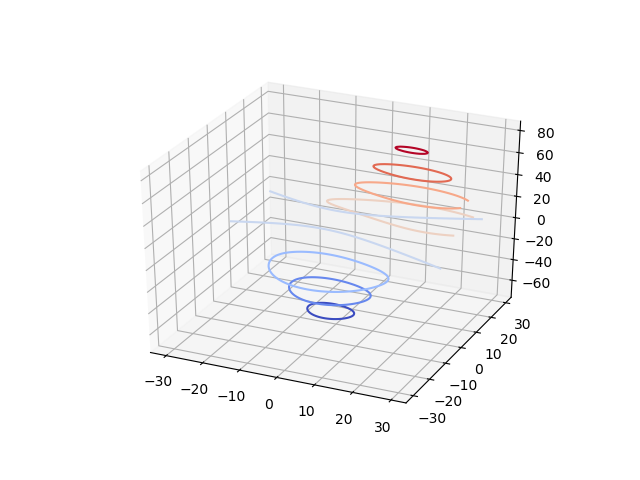

In [2]:
%matplotlib inline
%matplotlib notebook

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

# Plot contour curves
cset = ax.contour(X, Y, Z, cmap=cm.coolwarm)

ax.clabel(cset, fontsize=9, inline=1)

# plt.show()

